In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10584418584243633483,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10736808153455260077
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7220689277084451417
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14445006029
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 743848195459223716
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# load data

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

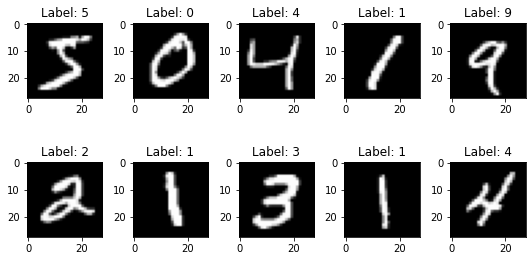

In [4]:
num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

# build model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape

In [6]:
x = Input(shape=(28, 28), name='Input')  # shape of input
z = Reshape((28, 28, 1), name='Reshape')(x)  # 28x28 -> 28x28x1
z = Conv2D(32, 3, name='Conv_0')(z)  # 28x28x1 -> 26x26x32
z = MaxPooling2D((2, 2), strides=(1, 1), name='Pool_0')(z)  # 26x26x32 -> 13x13x32
z = Conv2D(64, 3, name='Conv_1')(z)  # 13x13x32 -> 11x11x64
z = MaxPooling2D((3, 3), strides=(2, 2), name='Pool_1')(z)  # 11x11x64 -> 5x5x64
z = Flatten()(z)  # 5x5x64 -> 1600
z = Dense(units=128, activation='relu')(z)  # dense + ReLU
p = Dense(units=10, activation='softmax')(z)  # dense + softmax

model = Model(
    inputs=x,
    outputs=p,
)  # build DNN model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])  # compile model

In [7]:
# callbacks
callbacks = [
    EarlyStopping(patience=3),
    ModelCheckpoint(filepath=os.path.join('models', 'CNN', 'test.h5'), save_best_only=True),
]

In [8]:
# train
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 6s 116us/sample - loss: 1.8338 - acc: 0.9056 - val_loss: 0.1660 - val_acc: 0.9564
Epoch 2/100
48000/48000 [==============================] - 3s 58us/sample - loss: 0.1009 - acc: 0.9735 - val_loss: 0.1350 - val_acc: 0.9677
Epoch 3/100
48000/48000 [==============================] - 3s 58us/sample - loss: 0.0682 - acc: 0.9817 - val_loss: 0.0998 - val_acc: 0.9753
Epoch 4/100
48000/48000 [==============================] - 3s 57us/sample - loss: 0.0472 - acc: 0.9865 - val_loss: 0.1121 - val_acc: 0.9768
Epoch 5/100
48000/48000 [==============================] - 3s 57us/sample - loss: 0.0405 - acc: 0.9888 - val_loss: 0.1232 - val_acc: 0.9768
Epoch 6/100
48000/48000 [==============================] - 3s 57us/sample - loss: 0.0371 - acc: 0.9897 - val_loss: 0.1372 - val_acc: 0.9747


In [9]:
# see accuracy

accuracy_score(y_test, model.predict(x_test).argmax(axis=-1))

0.9749

このモデルの精度は 97.49% です。
Dense layer のみのものより高精度！

# compare models

In [10]:
from collections import OrderedDict

class CNNModel:
    def __init__(self, hid_dim_0=32, hid_dim_1=64):
        self.input = Input(shape=(28, 28), name='Input')  # shape of input
        self.reshape = Reshape((28, 28, 1), name='Reshape')  # 28x28 -> 28x28x1
        self.layers = OrderedDict()
        self.layers['conv_0'] = Conv2D(hid_dim_0, 3, name='Conv_0')  # 28x28x1 -> 26x26xhid_dim_0
        self.layers['pool_0'] = MaxPooling2D((2, 2), strides=(1, 1), name='Pool_0')  # 26x26xhid_dim_0 -> 13x13xhid_dim_0
        self.layers['conv_1'] = Conv2D(hid_dim_1, 3, name='Conv_1')  # 13x13xhid_dim_0 -> 11x11xhid_dim_1
        self.layers['pool_1'] = MaxPooling2D((3, 3), strides=(2, 2), name='Pool_1')  # 11x11xhid_dim_1 -> 5x5xhid_dim_1
        self.layers['flatten'] = Flatten()
        self.layers['dense_0'] = Dense(units=128, activation='relu')  # dense + ReLU
        self.last = Dense(units=10, activation='softmax', name='last')
    
    
    def build(self):
        x = self.input
        z = self.reshape(x)
        for layer in self.layers.values():
            z = layer(z)
        p = self.last(z)
        
        model = Model(inputs=x, outputs=p)
        
        return model

In [11]:
dim_hidden_layres = [2**i for i in range(4, 8)]

In [12]:
df_accuracy = pd.DataFrame()

for hid_dim_0 in dim_hidden_layres:
    for hid_dim_1 in dim_hidden_layres:
        print('========', 'hid_dim_0:', hid_dim_0, '; hid_dim_1:', hid_dim_1, '========')
        model = CNNModel(hid_dim_0=hid_dim_0, hid_dim_1=hid_dim_1)
        model = model.build()
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
        callbacks = [
            EarlyStopping(patience=3),
            ModelCheckpoint(filepath=os.path.join('models', 'CNN', 'model_{}_{}.h5'.format(hid_dim_0, hid_dim_1)), save_best_only=True),
        ]
        n_param = model.count_params()
        model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split=0.2)
        acc = accuracy_score(y_test, model.predict(x_test).argmax(axis=-1))
        
        df_accuracy = pd.concat([df_accuracy, pd.DataFrame([[hid_dim_0, hid_dim_1, n_param, acc]], columns=['hid_dim_0', 'hid_dim_1', 'n_param', 'accuracy'])])

======== hid_dim_0: 16 ; hid_dim_1: 16 ========
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 38us/sample - loss: 1.8417 - acc: 0.9029 - val_loss: 0.2222 - val_acc: 0.9536
Epoch 2/100
48000/48000 [==============================] - 1s 29us/sample - loss: 0.1294 - acc: 0.9690 - val_loss: 0.1487 - val_acc: 0.9679
Epoch 3/100
48000/48000 [==============================] - 1s 30us/sample - loss: 0.0727 - acc: 0.9804 - val_loss: 0.1405 - val_acc: 0.9697
Epoch 4/100
48000/48000 [==============================] - 1s 30us/sample - loss: 0.0461 - acc: 0.9868 - val_loss: 0.1171 - val_acc: 0.9745
Epoch 5/100
48000/48000 [==============================] - 1s 30us/sample - loss: 0.0367 - acc: 0.9892 - val_loss: 0.1252 - val_acc: 0.9732
Epoch 6/100
48000/48000 [==============================] - 1s 29us/sample - loss: 0.0347 - acc: 0.9895 - val_loss: 0.1337 - val_acc: 0.9754
Epoch 7/100
48000/48000 [==============================] - 1s 

In [13]:
display(df_accuracy.set_index(['hid_dim_0', 'hid_dim_1'])[['n_param']].unstack())
display(df_accuracy.set_index(['hid_dim_0', 'hid_dim_1'])[['accuracy']].unstack())

n_param                          
hid_dim_1     16      32       64       128
hid_dim_0                                  
16         251706  501834  1002090  2002602
32         254170  506602  1011466  2021194
64         259098  516138  1030218  2058378
128        268954  535210  1067722  2132746

accuracy                        
hid_dim_1      16      32      64      128
hid_dim_0                                 
16          0.9771  0.9746  0.9750  0.9799
32          0.9784  0.9743  0.9762  0.9814
64          0.9803  0.9807  0.9751  0.9814
128         0.9787  0.9804  0.9806  0.9775

In [14]:
df_accuracy.to_csv('cnn_results.csv')